In [1]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd '/content/drive/My Drive/Colab Notebooks/'

/content/drive/My Drive/Colab Notebooks


In [0]:
import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sn

import cv2
import glob

import tensorflow as tf
from tensorflow import keras

prep dataset

In [0]:
imgfiles_nostar = glob.glob('star64/nostar/*.jpg')
imgfiles_star = glob.glob('star64/star/*.jpg')
imgfiles_LEs = glob.glob('star64/le64/*.jpg')


In [5]:
N = [len(imgfiles_nostar), len(imgfiles_star), len(imgfiles_LEs)]
N

[507, 544, 428]

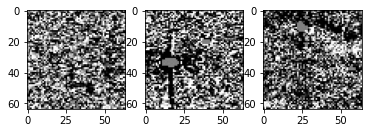

In [6]:
# show some images
img0 = cv2.imread(imgfiles_nostar[1])
img1 = cv2.imread(imgfiles_star[1])
img2 = cv2.imread(imgfiles_LEs[1])

fig, axs = pl.subplots(nrows=1, ncols=3, )

axs[0].imshow(img0)
axs[1].imshow(img1)
axs[2].imshow(img2)


In [7]:
img0.shape

(64, 64, 3)

In [0]:
def stack_imgs(imgfiles, imgshape=[64, 64, 3]):
    """stack image as numpy array """
    N_imgs = len(imgfiles)
    imgarr = np.zeros([N_imgs, imgshape[0], imgshape[1], imgshape[2]], dtype=np.uint8)
    for i, imf in enumerate( imgfiles):  
        imgarr[i] = np.asarray( cv2.imread( imf ))
        print('imread ', i, '/', N_imgs,  imf)
    return imgarr


In [0]:
# stack all images as numpy array uint8
imgs_nostar = stack_imgs(imgfiles_nostar) 
imgs_star = stack_imgs(imgfiles_star) 
imgs_LEs = stack_imgs(imgfiles_LEs) 

In [10]:
imgs_nostar.shape, imgs_star.shape, imgs_LEs.shape

((507, 64, 64, 3), (544, 64, 64, 3), (428, 64, 64, 3))

Text(0.5, 1.0, 'light echo')

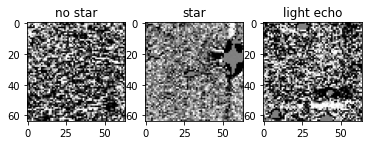

In [0]:
# show some images
fig, axs = pl.subplots(nrows=1, ncols=3, )

axs[0].imshow(imgs_nostar[3, :])
axs[0].set_title('no star')
axs[1].imshow(imgs_star[3, :])
axs[1].set_title('star')

axs[2].imshow(imgs_LEs[3, :])
axs[2].set_title('light echo')


In [0]:
# create labels
# nostar 0, star 1, light echo 2

y_nostar = np.zeros( (N[0], 1) )
y_star = np.ones( (N[1], 1) ) 
y_LEs = np.ones( (N[2], 1) ) * 2

In [12]:
X = np.concatenate( (imgs_nostar, imgs_star, imgs_LEs),  axis=0 )
X.shape

(1479, 64, 64, 3)

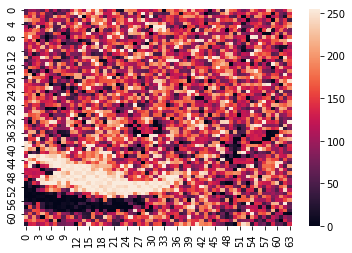

In [13]:
sn.heatmap(X[1200,:, :, 1], )

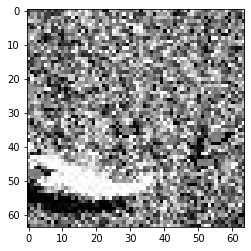

In [0]:
pl.imshow( X[1200,:, :, :]);

In [14]:
Y = np.concatenate( (y_nostar, y_star, y_LEs),  axis=0 )
Y.shape

(1479, 1)

In [0]:
# save X, Y to npz
np.savez('./star64/imgsXY.npz', X=X, Y=Y)

imgsXY = np.load('./star64/imgsXY.npz')
X = imgsXY['X']
Y = imgsXY['Y']

split train and test

In [0]:
# shuffle and split 
from sklearn.model_selection import train_test_split

Xn = X / 255.  # normalize 
X_train, X_test, y_train, y_test = train_test_split(Xn, Y, test_size=0.33, shuffle=True, random_state=42)


In [17]:
X_train.shape, y_train.shape

((990, 64, 64, 3), (990, 1))

In [18]:
np.unique(y_train, return_counts=True)

(array([0., 1., 2.]), array([340, 366, 284]))

In [0]:
# one hot encoding the labels
y_train_onehot = keras.utils.to_categorical(y_train)
y_test_onehot = keras.utils.to_categorical(y_test)

In [20]:
y_train_onehot.shape

(990, 3)

In [21]:
y_train_onehot[0, :]

array([0., 1., 0.], dtype=float32)

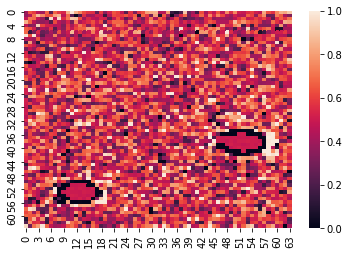

In [0]:
sn.heatmap(X_train[0, :, :, 0])

### Building models

simple neural network

In [0]:
model = keras.Sequential([keras.layers.Flatten(input_shape=(64, 64, 1)),
                         #keras.layers.Dense(1024, activation=tf.nn.relu),  
                         # keras.layers.Dense(256, activation=tf.nn.relu),
                         #keras.layers.Dense(512, activation=tf.nn.relu), 
                         keras.layers.Dense(256, activation=tf.nn.relu), 
                         keras.layers.Dense(128, activation=tf.nn.relu), 
                         keras.layers.Dense(64, activation=tf.nn.relu), 
                         keras.layers.Dense(32, activation=tf.nn.relu),
                         keras.layers.Dense(16, activation=tf.nn.relu),
                         keras.layers.Dense(8, activation=tf.nn.relu),
                         keras.layers.Dense(3, activation=tf.nn.sigmoid) ])


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1048832   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 1

In [0]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])


In [25]:
X_train.shape

(990, 64, 64, 3)

In [26]:
history = model.fit(X_train[:,:,:,1].reshape(X_train.shape[0], 64, 64, 1), y_train_onehot, epochs=15)


Epoch 1/15
31/31 [==============================] - 0s 5ms/step - loss: 1.0993 - accuracy: 0.3434
Epoch 2/15
31/31 [==============================] - 0s 4ms/step - loss: 1.0938 - accuracy: 0.3434
Epoch 3/15
31/31 [==============================] - 0s 4ms/step - loss: 1.0854 - accuracy: 0.3758
Epoch 4/15
31/31 [==============================] - 0s 5ms/step - loss: 1.0674 - accuracy: 0.4414
Epoch 5/15
31/31 [==============================] - 0s 4ms/step - loss: 1.0515 - accuracy: 0.4657
Epoch 6/15
31/31 [==============================] - 0s 5ms/step - loss: 1.0159 - accuracy: 0.4707
Epoch 7/15
31/31 [==============================] - 0s 5ms/step - loss: 0.9506 - accuracy: 0.5525
Epoch 8/15
31/31 [==============================] - 0s 4ms/step - loss: 0.9055 - accuracy: 0.5556
Epoch 9/15
31/31 [==============================] - 0s 4ms/step - loss: 0.8358 - accuracy: 0.6222
Epoch 10/15
31/31 [==============================] - 0s 5ms/step - loss: 0.7688 - accuracy: 0.6313
Epoch 11/15
31/31 [

In [27]:
df_history = pd.DataFrame(history.history)
df_history

,loss,accuracy
0,1.099313,0.343434
1,1.093790,0.343434
2,1.085382,0.375758
3,1.067410,0.441414
4,1.051470,0.465657
5,1.015948,0.470707
6,0.950641,0.552525
7,0.905505,0.555556
8,0.835831,0.622222
9,0.768786,0.631313


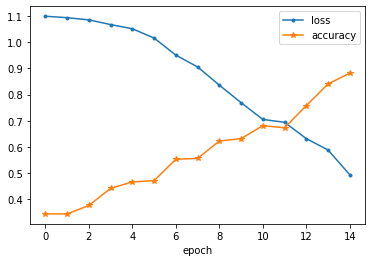

In [28]:
pl.plot(df_history.loss, '.-', label='loss')
pl.plot(df_history.accuracy, '*-', label='accuracy')
pl.xlabel('epoch')
pl.legend()

In [29]:
np.unique( y_test, return_counts=True )

(array([0., 1., 2.]), array([167, 178, 144]))

In [30]:
# evaulate model
test_loss, test_acc = model.evaluate(X_test[:,:,:,1].reshape( X_test.shape[0], 64, 64, 1 ), y_test_onehot)


16/16 [==============================] - 0s 3ms/step - loss: 1.1502 - accuracy: 0.4315


Convolutional 2D model

In [0]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D


In [0]:
#create model
model_cnn = keras.Sequential()
#add model layers

model_cnn.add(Conv2D(8, kernel_size=3, activation='relu', input_shape=(64,64, 1)))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(16, kernel_size=3, activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(32, kernel_size=3, activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(16, kernel_size=3, activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Flatten())
model_cnn.add(Dense(units = 16, activation = 'relu'))
model_cnn.add(Dense(3, activation='sigmoid'))


In [46]:
model_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 62, 62, 8)         80        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 31, 31, 8)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 29, 29, 16)        1168      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 16)         

In [0]:
model_cnn.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])


In [48]:
history = model_cnn.fit(X_train[:,:,:,1].reshape(X_train.shape[0], 64, 64, 1), y_train_onehot, epochs=30)


Epoch 1/30
31/31 [==============================] - 0s 7ms/step - loss: 1.0960 - accuracy: 0.3697
Epoch 2/30
31/31 [==============================] - 0s 7ms/step - loss: 1.0909 - accuracy: 0.3697
Epoch 3/30
31/31 [==============================] - 0s 7ms/step - loss: 1.0774 - accuracy: 0.4263
Epoch 4/30
31/31 [==============================] - 0s 7ms/step - loss: 1.0356 - accuracy: 0.4909
Epoch 5/30
31/31 [==============================] - 0s 7ms/step - loss: 0.9416 - accuracy: 0.5747
Epoch 6/30
31/31 [==============================] - 0s 7ms/step - loss: 0.8937 - accuracy: 0.5889
Epoch 7/30
31/31 [==============================] - 0s 7ms/step - loss: 0.9292 - accuracy: 0.5545
Epoch 8/30
31/31 [==============================] - 0s 7ms/step - loss: 0.8098 - accuracy: 0.6263
Epoch 9/30
31/31 [==============================] - 0s 7ms/step - loss: 0.7931 - accuracy: 0.6515
Epoch 10/30
31/31 [==============================] - 0s 7ms/step - loss: 0.7146 - accuracy: 0.6687
Epoch 11/30
31/31 [

In [49]:
# evaulate model
test_loss, test_acc = model_cnn.evaluate(X_test[:,:,:,1].reshape( X_test.shape[0], 64, 64, 1 ), y_test_onehot)


16/16 [==============================] - 0s 8ms/step - loss: 0.4381 - accuracy: 0.8016


In [0]:
df_history = pd.DataFrame(history.history)

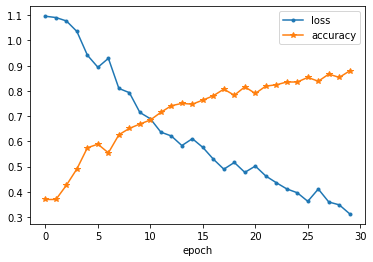

In [52]:
pl.plot(df_history.loss, '.-', label='loss')
pl.plot(df_history.accuracy, '*-', label='accuracy')
pl.xlabel('epoch')
pl.legend()

feature extractor

In [0]:
layer0 = model_cnn.layers[0]

In [70]:
len(layer0.weights)

2

In [75]:
filters0 = layer0.weights[0].numpy()    # all filters used in layers
filters0.shape

(3, 3, 1, 8)

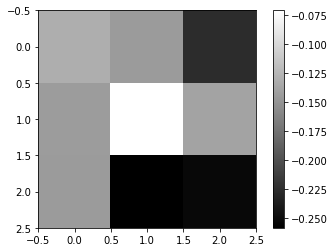

In [80]:
pl.imshow(filters0[:,:,0,0], cmap='gray')
pl.colorbar()

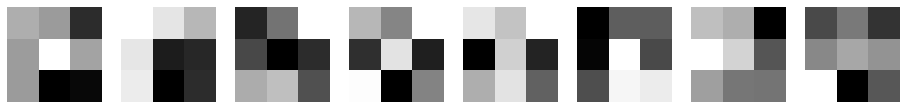

In [94]:
fig, axs = pl.subplots(nrows=1, ncols=8, figsize=(16, 6) )

for i in range(8):
    axs[i].imshow( filters0[:,:,0, i], cmap='gray')
    axs[i].axis('off')

In [0]:
extractor = keras.Model(inputs=model_cnn.inputs,
                        outputs=[layer.output for layer in model_cnn.layers])


In [101]:
Y[1200]

array([2.])

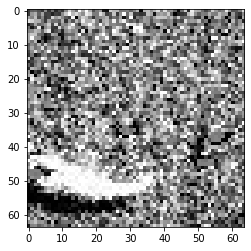

In [103]:
img_ = X[1200, :, :, 0]
pl.imshow(img_, cmap='gray')


In [0]:
features = extractor(img_.reshape(1, 64, 64, 1 ))


In [105]:
len( features )

11

In [106]:
features[2].numpy().shape

(1, 29, 29, 16)

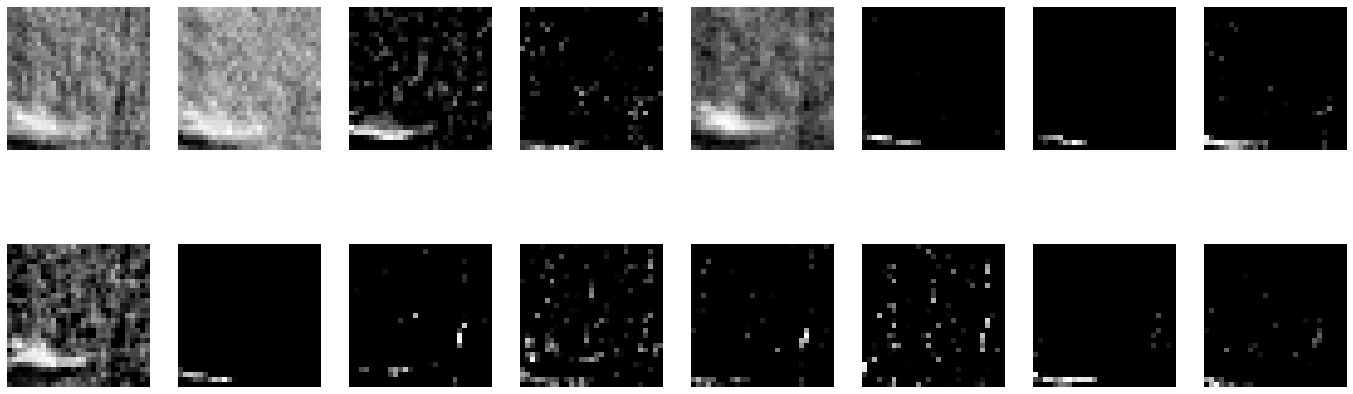

In [110]:
fig, axs = pl.subplots(nrows=2, ncols=8, figsize=(24, 8) )
axs = axs.ravel()
for i in range(16):
    axs[i].imshow( features[2].numpy() [0,:,:, i], cmap='gray')
    axs[i].axis('off')
